In [3]:
from math import sqrt
import random

def readfile(filename):
    lines = [line for line in file(filename)]

  # First line is the column titles
    colnames = lines[0].strip().split('\t')[1:]
    rownames = []
    data = []
    for line in lines[1:]:
        p = line.strip().split('\t')
    # First column in each row is the rowname
        rownames.append(p[0])
    # The data for this row is the remainder of the row
        data.append([float(x) for x in p[1:]])
    return (rownames, colnames, data)

In [3]:
blognames,words,data = readfile('blogdata.txt')

In [4]:
def cosine(v1, v2):
    inner_product = sum([ v1[i]*v2[i] for i in range(len(v1))])
    length_v1 = sqrt(sum([ v1[i]*v1[i] for i in range(len(v1))]))
    length_v2 = sqrt(sum([ v2[i]*v2[i] for i in range(len(v2))]))
    cosine= inner_product/(length_v1*length_v2)
    return cosine

In [6]:
cosine([1,4],[1,4])

1.0

0.0

In [6]:
class bicluster:

    def __init__(
        self,
        vec,
        left=None,
        right=None,
        distance=0.0,
        id=None,
        ):
        self.left = left
        self.right = right
        self.vec = vec
        self.id = id
        self.distance = distance


def hcluster(rows, distance=cosine):
    distances = {}
    currentclustid = -1

  # Clusters are initially just the rows
    clust = [bicluster(rows[i], id=i) for i in range(len(rows))]

    while len(clust) > 1:
        lowestpair = (0, 1)
        closest = distance(clust[0].vec, clust[1].vec)

    # loop through every pair looking for the smallest distance
        for i in range(len(clust)):
            for j in range(i + 1, len(clust)):
        # distances is the cache of distance calculations
                if (clust[i].id, clust[j].id) not in distances:
                    distances[(clust[i].id, clust[j].id)] = \
                        distance(clust[i].vec, clust[j].vec)

                d = distances[(clust[i].id, clust[j].id)]

                if d < closest:
                    closest = d
                    lowestpair = (i, j)

    # calculate the average of the two clusters
        mergevec = [(clust[lowestpair[0]].vec[i] + clust[lowestpair[1]].vec[i])
                    / 2.0 for i in range(len(clust[0].vec))]

    # create the new cluster
        newcluster = bicluster(mergevec, left=clust[lowestpair[0]],
                               right=clust[lowestpair[1]], distance=closest,
                               id=currentclustid)

    # cluster ids that weren't in the original set are negative
        currentclustid -= 1
        del clust[lowestpair[1]]
        del clust[lowestpair[0]]
        clust.append(newcluster)

    return clust[0]

In [7]:
cluster_result = hcluster(data)

In [8]:
def getheight(clust):
  # Is this an endpoint? Then the height is just 1
    if clust.left == None and clust.right == None:
        return 1

  # Otherwise the height is the same of the heights of
  # each branch
    return getheight(clust.left) + getheight(clust.right)


def getdepth(clust):
  # The distance of an endpoint is 0.0
    if clust.left == None and clust.right == None:
        return 0

  # The distance of a branch is the greater of its two sides
  # plus its own distance
    return max(getdepth(clust.left), getdepth(clust.right)) + clust.distance


def drawdendrogram(clust, labels, jpeg='clusters.jpg'):
  # height and width
    h = getheight(clust) * 20
    w = 1200
    depth = getdepth(clust)

  # width is fixed, so scale distances accordingly
    scaling = float(w - 150) / depth

  # Create a new image with a white background
    img = Image.new('RGB', (w, h), (255, 255, 255))
    draw = ImageDraw.Draw(img)

    draw.line((0, h / 2, 10, h / 2), fill=(255, 0, 0))

  # Draw the first node
    drawnode(
        draw,
        clust,
        10,
        h / 2,
        scaling,
        labels,
        )
    img.save(jpeg, 'JPEG')


def drawnode(
    draw,
    clust,
    x,
    y,
    scaling,
    labels,
    ):
    if clust.id < 0:
        h1 = getheight(clust.left) * 20
        h2 = getheight(clust.right) * 20
        top = y - (h1 + h2) / 2
        bottom = y + (h1 + h2) / 2
    # Line length
        ll = clust.distance * scaling
    # Vertical line from this cluster to children
        draw.line((x, top + h1 / 2, x, bottom - h2 / 2), fill=(255, 0, 0))

    # Horizontal line to left item
        draw.line((x, top + h1 / 2, x + ll, top + h1 / 2), fill=(255, 0, 0))

    # Horizontal line to right item
        draw.line((x, bottom - h2 / 2, x + ll, bottom - h2 / 2), fill=(255, 0,
                  0))

    # Call the function to draw the left and right nodes
        drawnode(
            draw,
            clust.left,
            x + ll,
            top + h1 / 2,
            scaling,
            labels,
            )
        drawnode(
            draw,
            clust.right,
            x + ll,
            bottom - h2 / 2,
            scaling,
            labels,
            )
    else:
    # If this is an endpoint, draw the item label
        draw.text((x + 5, y - 7), labels[clust.id], (0, 0, 0))

In [9]:
from PIL import Image, ImageDraw
drawdendrogram(cluster_result,blognames,jpeg='blogclust.jpg')

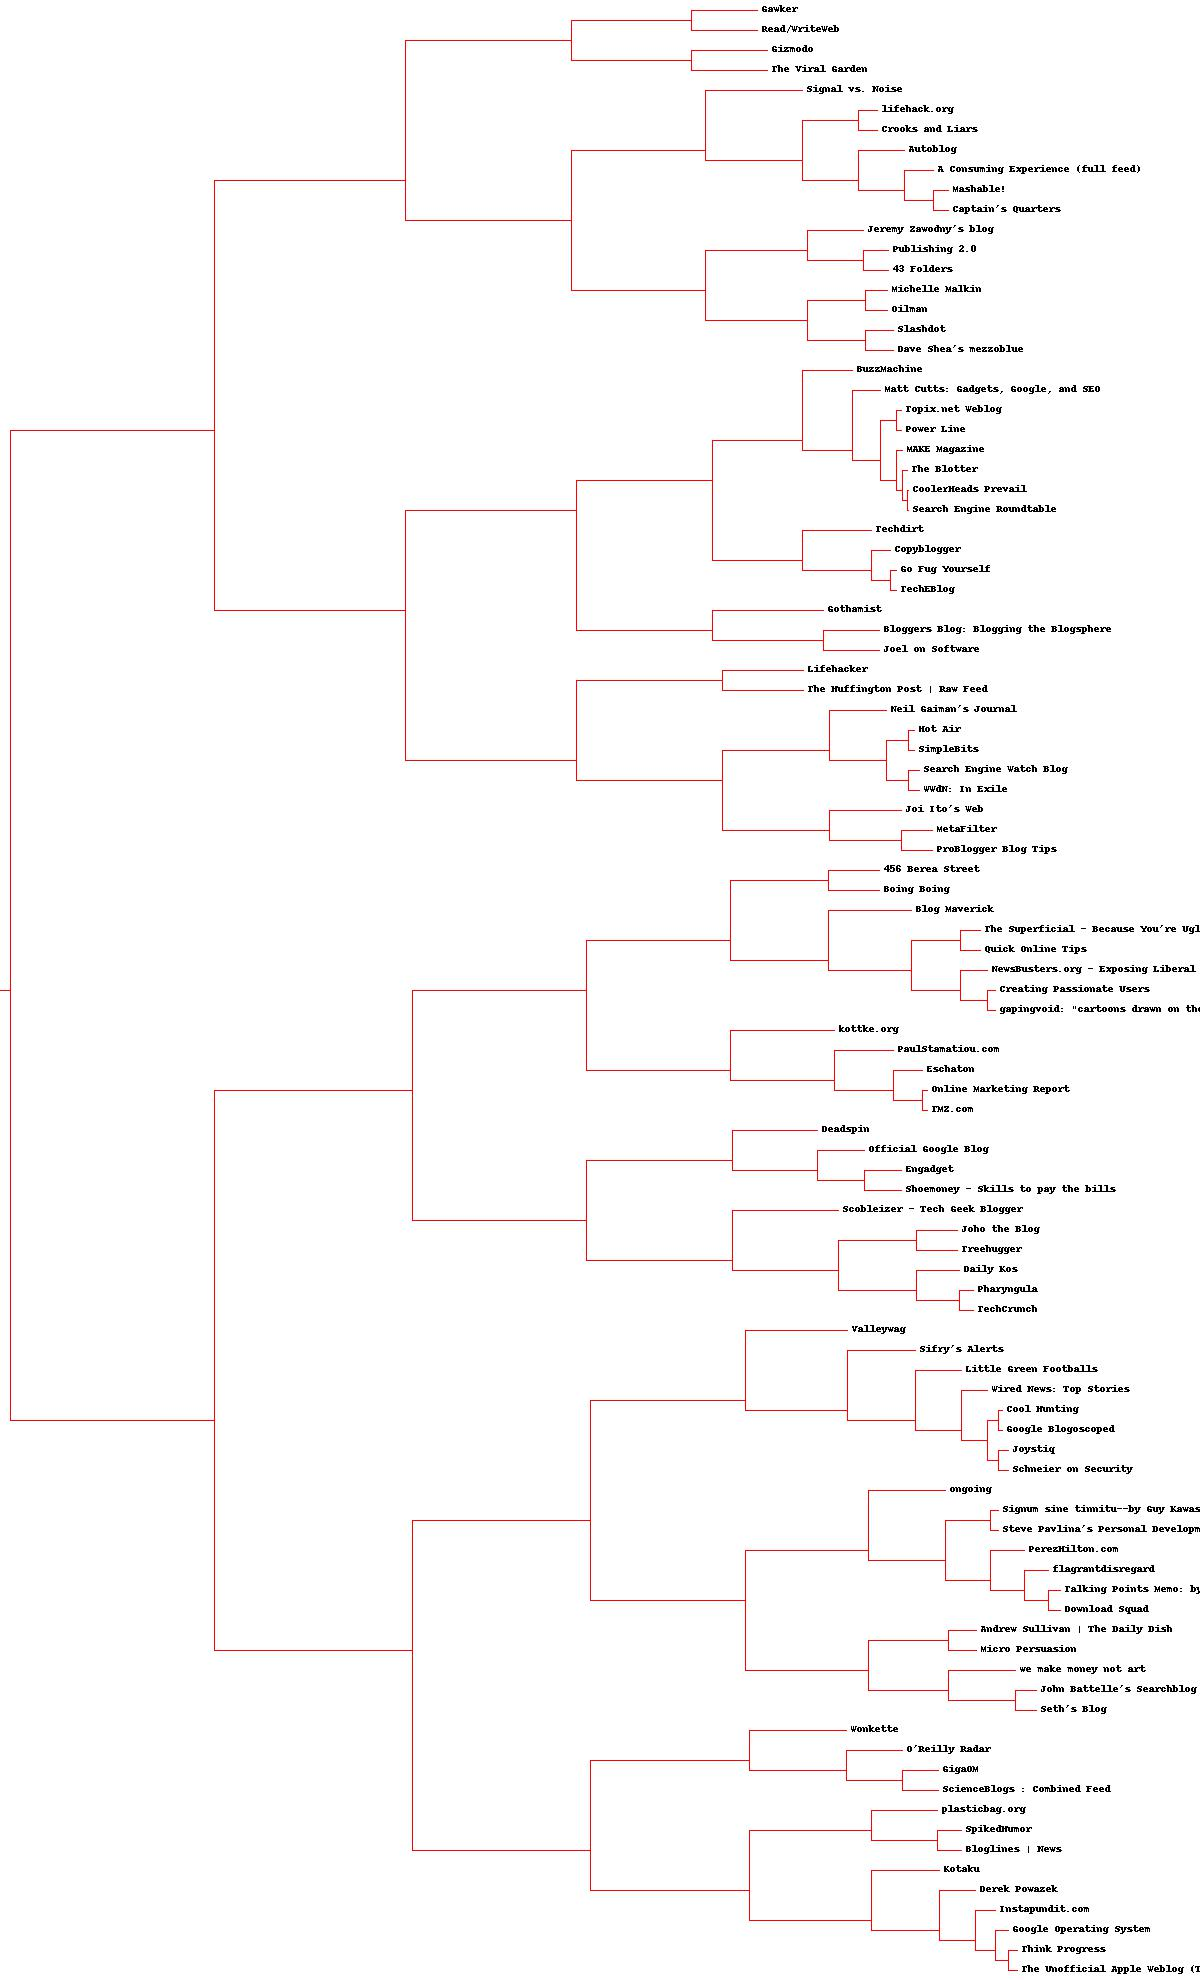

In [10]:
from IPython.display import Image
Image(filename='blogclust.jpg')